In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [70]:
data_bank = pd.read_csv('../1 data/new_data/train_dataset/train_public.csv')
data_test = pd.read_csv('../1 data/new_data/test_public.csv')
data_bank.rename(columns={'isDefault': 'is_default'}, inplace=True)
data_test['is_default'] = -1

In [71]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   5000 non-null   int64  
 1   user_id                   5000 non-null   int64  
 2   total_loan                5000 non-null   float64
 3   year_of_loan              5000 non-null   int64  
 4   interest                  5000 non-null   float64
 5   monthly_payment           5000 non-null   float64
 6   class                     5000 non-null   object 
 7   employer_type             5000 non-null   object 
 8   industry                  5000 non-null   object 
 9   work_year                 4722 non-null   object 
 10  house_exist               5000 non-null   int64  
 11  censor_status             5000 non-null   int64  
 12  issue_date                5000 non-null   object 
 13  use                       5000 non-null   int64  
 14  post_cod

In [72]:
data_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   10000 non-null  int64  
 1   user_id                   10000 non-null  int64  
 2   total_loan                10000 non-null  float64
 3   year_of_loan              10000 non-null  int64  
 4   interest                  10000 non-null  float64
 5   monthly_payment           10000 non-null  float64
 6   class                     10000 non-null  object 
 7   employer_type             10000 non-null  object 
 8   industry                  10000 non-null  object 
 9   work_year                 9378 non-null   object 
 10  house_exist               10000 non-null  int64  
 11  censor_status             10000 non-null  int64  
 12  issue_date                10000 non-null  object 
 13  use                       10000 non-null  int64  
 14  post_co

In [73]:
total_df = data_bank.append(data_test)
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   15000 non-null  int64  
 1   user_id                   15000 non-null  int64  
 2   total_loan                15000 non-null  float64
 3   year_of_loan              15000 non-null  int64  
 4   interest                  15000 non-null  float64
 5   monthly_payment           15000 non-null  float64
 6   class                     15000 non-null  object 
 7   employer_type             15000 non-null  object 
 8   industry                  15000 non-null  object 
 9   work_year                 14100 non-null  object 
 10  house_exist               15000 non-null  int64  
 11  censor_status             15000 non-null  int64  
 12  issue_date                15000 non-null  object 
 13  use                       15000 non-null  int64  
 14  post_co

## 预处理

In [74]:
# total_df.select_dtypes('object').columns #'industry', 'issue_date', 'work_year', 'earlies_credit_mon', 'class','employer_type'

from sklearn.preprocessing import OrdinalEncoder
import re

# industry
oen = OrdinalEncoder()
total_df[['industry']] = oen.fit_transform(total_df[['industry']])

# class
class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
total_df['class'] = total_df['class'].map(class_dict)


# employer_type，不再顺序编码，而是one-hot编码
# employer_type_dict = {
#     '政府机构': 5,
#     '世界五百强': 4,
#     '上市企业': 3,
#     '高等教育机构': 2,
#     '普通企业': 1,
#     '幼教与中小学校': 0
# }
#
# total_df.employer_type = total_df.employer_type.map(employer_type_dict)
def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-' + val
    else:
        return val + '-01'


total_df.earlies_credit_mon = pd.to_datetime(total_df.earlies_credit_mon.map(findDig))


# work_year
def workYearDic(x):
    if str(x) == 'nan':
        return -1
    if str(x) == '10+ years':
        return 15
    x = x.replace('< 1', '0')
    return int(re.search('(\d+)', x).group())


total_df.work_year = total_df.work_year.map(workYearDic)

# issue_date
total_df.issue_date = pd.to_datetime(total_df.issue_date)

## 特征工程
* 时间特征
* post_code对interest的特征和对early return amount, early return amount 3mon, monthly payment的特征
* employer type独热编码
* credit item( monthly payment / total_loan特征)
* revenue( total_loan / debt_loan_ratio特征)
* post_code 对 revenue特征

In [75]:
##时间特征
total_df['issue_date_year'] = total_df['issue_date'].dt.year
total_df['issue_date_mon'] = total_df['issue_date'].dt.month

total_df['earlies_credit_year'] = total_df['earlies_credit_mon'].dt.year
total_df['earlies_credit_mon'] = total_df['earlies_credit_mon'].dt.month

In [76]:
# post_code对interst、 early return amount, early return amount 3mon, monthly payment 特征 mean, std
region_feats = []
for col in ['interest', 'early_return_amount', 'early_return_amount_3mon', 'monthly_payment', 'user_id']:
    for sta in ['mean', 'std']:
        total_df[f'regionally_{sta}_of_{col}'] = total_df.groupby(['post_code'])[col].transform(sta)

        region_feats.append(f'regionally_{sta}_of_{col}')
print(region_feats, len(region_feats))

['regionally_mean_of_interest', 'regionally_std_of_interest', 'regionally_mean_of_early_return_amount', 'regionally_std_of_early_return_amount', 'regionally_mean_of_early_return_amount_3mon', 'regionally_std_of_early_return_amount_3mon', 'regionally_mean_of_monthly_payment', 'regionally_std_of_monthly_payment', 'regionally_mean_of_user_id', 'regionally_std_of_user_id'] 10


In [77]:
import seaborn as sns
# f, ax = plt.subplots(2,5, figsize = (24,10))
# # print(ax[1,0])
# i = 0
# for i, col in enumerate(['interest','early_return_amount','early_return_amount_3mon','monthly_payment','user_id']):
#     for j, sta in enumerate(['mean','std']):
#         sns.lmplot(x = total_df[[f'regionally_{sta}_of_{col}']], y = total_df.is_default, hue = total_df.is_default, data = data_bank)
#         # plt.legend()
# plt.show()

# sns.catplot(x = 'regionally_mean_of_interest', y = 'is_default', data = total_df[total_df.is_default!=-1], kind = 'box')


In [78]:
# total_df[region_feats].fillna(0, inplace = True)
# total_df[region_feats].isnull().sum()

# from sklearn.feature_selection import mutual_info_classif
# mutual_info_classif(total_df[region_feats], total_df.is_default)



In [79]:
# 对employer-type 进行one-hot 编码

from sklearn.preprocessing import OneHotEncoder

# ohe = OneH2otEncoder(handle_unknown='ignore', sparse=False)
# employer_type_matrix =pd.DataFrame(ohe.fit_transform(total_df[['employer_type']]))
# employer_type_matrix

employer_type_matrix = pd.get_dummies(total_df['employer_type'], prefix='industry')
employer_type_matrix.index = total_df.index
employer_type_matrix.info()
total_df = pd.concat([total_df, employer_type_matrix], axis=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   industry_上市企业     15000 non-null  uint8
 1   industry_世界五百强    15000 non-null  uint8
 2   industry_幼教与中小学校  15000 non-null  uint8
 3   industry_政府机构     15000 non-null  uint8
 4   industry_普通企业     15000 non-null  uint8
 5   industry_高等教育机构   15000 non-null  uint8
dtypes: uint8(6)
memory usage: 205.1 KB


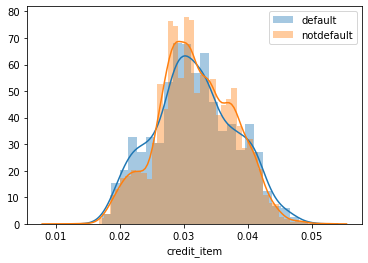

In [80]:
# credit_item
total_df['credit_item'] = total_df['monthly_payment'] / total_df['total_loan']
sns.distplot(total_df[total_df['is_default'] == 1]['credit_item'], label='default')
sns.distplot(total_df[total_df['is_default'] == 0]['credit_item'], label='notdefault')
plt.legend()
plt.show()

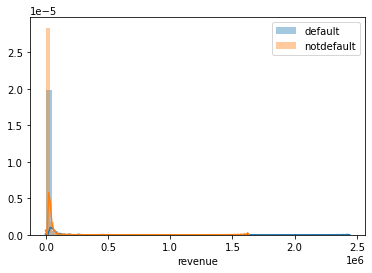

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 60 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   loan_id                                      15000 non-null  int64         
 1   user_id                                      15000 non-null  int64         
 2   total_loan                                   15000 non-null  float64       
 3   year_of_loan                                 15000 non-null  int64         
 4   interest                                     15000 non-null  float64       
 5   monthly_payment                              15000 non-null  float64       
 6   class                                        15000 non-null  int64         
 7   employer_type                                15000 non-null  object        
 8   industry                                     15000 non-null  float64       
 

In [81]:
# revenue
total_df['revenue'] = total_df['total_loan'] / (total_df['debt_loan_ratio'] / 12)

total_df['revenue'] = total_df['revenue'].replace(np.inf, np.nan)

sns.distplot(total_df[total_df['is_default'] == 1]['revenue'], label='default')
sns.distplot(total_df[total_df['is_default'] == 0]['revenue'], label='notdefault')
plt.legend()
plt.show()
total_df['revenue'].describe()
total_df.info()

In [82]:
total_df['regionally_mean_of_revenue'] = total_df.groupby(['post_code'])['revenue'].transform('mean')
# sns.distplot(total_df['regionally_mean_of_revenue'])

## 模型选择

In [83]:
from sklearn.model_selection import cross_val_score
# LR, RF, xgboost, lightgbm,SVM
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from warnings import filterwarnings
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
filterwarnings('ignore')

#sklearn.metrics.SCORERS.keys() ['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']
# lr = LogisticRegression()
# rf = RandomForestClassifier()
# xgb = XGBClassifier()
# lgb = LGBMClassifier()
# svc = SVC()
# def select_model(models):
#     for i, model in enumerate(models):
#         scores = cross_val_score(model, feats, target, cv = 5, scoring = 'roc_auc')
#         print(f'第{i+1}个模型', scores.mean())
#
#
# models = [lr, rf, xgb, lgb, svc]
# select_model(models)

## 模型训练

In [89]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


def train_model(df, test_df, kfold):
    sub_preds = np.zeros(test_df.shape[0])
    feats = df.copy()
    target = feats.pop('is_default')
    test_feats = test_df.copy()
    for train_idx, valid_idx in kfold.split(df):
        train_X, train_y = feats.iloc[train_idx], target.iloc[train_idx]
        valid_X, valid_y = feats.iloc[valid_idx], target.iloc[valid_idx]
        random_seed = np.random.randint(0, 100000)
        print('random seed: ', random_seed)
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.01,
            num_leaves=2 ** 4,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,  #原本是5
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
            min_child_samples = 50,
            random_seed=random_seed
        )
        clf.fit(train_X, train_y, eval_set=[(train_X, train_y), (valid_X, valid_y)], early_stopping_rounds=30,
                eval_metric='auc', verbose=0)
        print('clf best score:', clf.best_score_, 'clf best iteration:', clf.best_iteration_)
        sub_preds += clf.predict_proba(test_feats)[:, 1]
    sub_preds = sub_preds / kfold.n_splits
    pred = pd.DataFrame({'id': test_df.loan_id, 'isDefault': sub_preds})
    return pred


In [90]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=2021)
df = total_df[total_df['is_default'] != -1].drop(['employer_type', 'issue_date'], axis=1)
test_df = total_df[total_df['is_default'] == -1].drop(['employer_type', 'is_default', 'issue_date'], axis=1)

feats = df.copy()
target = feats.pop('is_default')
test_feats = test_df.copy()
# test_df.info()
# df.info()
pred = train_model(df, test_df, kfold=kfold)
pred

random seed:  82430
clf best score: defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.8993589529379004), ('binary_logloss', 0.37676534330267747)]), 'valid_1': OrderedDict([('auc', 0.8692009345878572), ('binary_logloss', 0.3812139015113364)])}) clf best iteration: 39
random seed:  18270
clf best score: defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.9264613182130739), ('binary_logloss', 0.2593156917552399)]), 'valid_1': OrderedDict([('auc', 0.8917183100529592), ('binary_logloss', 0.2985773862787696)])}) clf best iteration: 431
random seed:  58153
clf best score: defaultdict(<class 'collections.OrderedDict'>, {'training': OrderedDict([('auc', 0.9182434532586773), ('binary_logloss', 0.27452372718675594)]), 'valid_1': OrderedDict([('auc', 0.8919265087157988), ('binary_logloss', 0.3052777379375896)])}) clf best iteration: 279
random seed:  67678
clf best score: defaultdict(<class 'collections.OrderedDict'>, {'training': Ord

,id,isDefault
0,1000575,0.049220
1,1028125,0.081923
2,1010694,0.043421
3,1026712,0.042037
4,1002895,0.045317
...,...,...
4995,1008856,0.345132
4996,1016651,0.051936
4997,1024140,0.041419
4998,1014316,0.049007


In [86]:
pred.to_csv('./lightgbm_单表+6特征.csv', index=False)